## 准备工作

![title](image/job_schedule.png)

In [3]:
# 一个简单的车间作业问题示例, 其中每个作业都用一对数字(m, p)标记. 其中 m 是任务必须加工的机器号, p 是任务的加工时间(任务和机器的编号从0开始)
# 作业 0 = (0, 3), (1, 2), (2, 2)  
# 作业 1 = (0, 2), (2, 1), (1, 4)  
# 作业 2 = (1, 4), (2, 3)  
# 在这个例子中, 作业0有三个任务. 第一个是(0, 3), 必须在机器0上加工3个时间单位. 第二个是(1, 2), 必须在机器1上加工2个时间单位, 依次类推.

"""Minimal jobshop example."""
import collections
import matplotlib.pyplot as plt
from ortools.sat.python import cp_model

"""Minimal jobshop problem."""
# Data.
jobs_data = [  # task = (machine_id, processing_time).
    [(0, 4), (1, 2), (2, 2)],  # Job0
    [(0, 2), (2, 1), (1, 4)],  # Job1
    [(1, 4), (2, 3)],  # Job2
]

machines_count = 1 + max(task[0] for job in jobs_data for task in job)
all_machines = range(machines_count)
# Computes horizon dynamically as the sum of all durations.
horizon = sum(task[1] for job in jobs_data for task in job)

# Create the model.
model = cp_model.CpModel()

# Named tuple to store information about created variables.
task_type = collections.namedtuple("task_type", "start end interval")
# Named tuple to manipulate solution information.
assigned_task_type = collections.namedtuple(
    "assigned_task_type", "start job index duration"
)

# Creates job intervals and add to the corresponding machine lists.
all_tasks = {}
machine_to_intervals = collections.defaultdict(list)

for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        machine, duration = task
        suffix = f"_{job_id}_{task_id}"
        start_var = model.NewIntVar(0, horizon, "start" + suffix)
        end_var = model.NewIntVar(0, horizon, "end" + suffix)
        interval_var = model.NewIntervalVar(
            start_var, duration, end_var, "interval" + suffix
        )
        all_tasks[job_id, task_id] = task_type(
            start=start_var, end=end_var, interval=interval_var
        )
        machine_to_intervals[machine].append(interval_var)

# Create and add disjunctive constraints.
for machine in all_machines:
    model.AddNoOverlap(machine_to_intervals[machine])

# Precedences inside a job.
for job_id, job in enumerate(jobs_data):
    for task_id in range(len(job) - 1):
        model.Add(
            all_tasks[job_id, task_id + 1].start >= all_tasks[job_id, task_id].end
        )

# Makespan objective.
obj_var = model.NewIntVar(0, horizon, "makespan")
model.AddMaxEquality(
    obj_var,
    [all_tasks[job_id, len(job) - 1].end for job_id, job in enumerate(jobs_data)],
)
model.Minimize(obj_var)

# Creates the solver and solve.
solver = cp_model.CpSolver()
status = solver.Solve(model)

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("Solution:")
    # Create one list of assigned tasks per machine.
    assigned_jobs = collections.defaultdict(list)
    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine = task[0]
            assigned_jobs[machine].append(
                assigned_task_type(
                    start=solver.Value(all_tasks[job_id, task_id].start),
                    job=job_id,
                    index=task_id,
                    duration=task[1],
                )
            )

    # Create per machine output lines.
    output = ""
    for machine in all_machines:
        # Sort by starting time.
        assigned_jobs[machine].sort()
        sol_line_tasks = "Machine " + str(machine) + ": "
        sol_line = "           "

        for assigned_task in assigned_jobs[machine]:
            name = f"job_{assigned_task.job}_task_{assigned_task.index}"
            # Add spaces to output to align columns.
            sol_line_tasks += f"{name:15}"

            start = assigned_task.start
            duration = assigned_task.duration
            sol_tmp = f"[{start},{start + duration}]"
            # Add spaces to output to align columns.
            sol_line += f"{sol_tmp:15}"

        sol_line += "\n"
        sol_line_tasks += "\n"
        output += sol_line_tasks
        output += sol_line

    # Finally print the solution found.
    print(f"Optimal Schedule Length: {solver.ObjectiveValue()}")
    print(output)
else:
    print("No solution found.")

# Statistics.
print("\nStatistics")
print(f"  - 冲突: {solver.NumConflicts()}")
print(f"  - 决策分支: {solver.NumBranches()}")
print(f"  - 计算时间: {solver.WallTime()}s")

Solution:
Optimal Schedule Length: 12.0
Machine 0: job_0_task_0   job_1_task_0   
           [0,4]          [4,6]          
Machine 1: job_2_task_0   job_0_task_1   job_1_task_2   
           [0,4]          [4,6]          [8,12]         
Machine 2: job_2_task_1   job_1_task_1   job_0_task_2   
           [4,7]          [7,8]          [8,10]         


Statistics
  - 冲突: 0
  - 决策分支: 0
  - 计算时间: 0.015414500000000001s


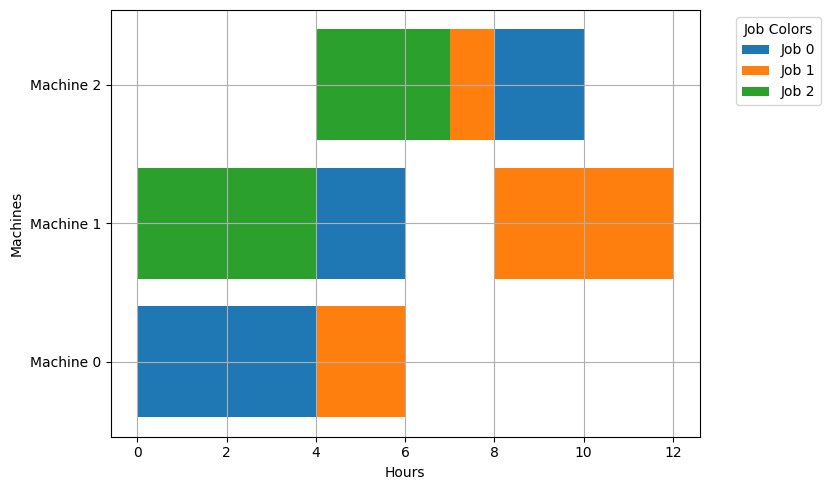

In [5]:
# We will recreate the Gantt chart with labels for each job
tasks = {
    "Machine 0": [("job_0_task_0", 0, 4), ("job_1_task_0", 4, 6)],
    "Machine 1": [("job_2_task_0", 0, 4), ("job_0_task_1", 4, 6), ("job_1_task_2", 8, 12)],
    "Machine 2": [("job_2_task_1", 4, 7), ("job_1_task_1", 7, 8), ("job_0_task_2", 8, 10)]
}

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Set labels for axes
ax.set_xlabel('Hours')
ax.set_ylabel('Machines')

# Set y-ticks to machine names
ax.set_yticks(range(len(tasks)))
ax.set_yticklabels(list(tasks.keys()))

# Set grid
ax.grid(True)

# Initialize a color map
colors = plt.cm.tab10

# To ensure each job has a unique color, we create a mapping from job to color index
color_mapping = {}
color_index = 0

# We will also keep track of labels to avoid duplicates in the legend
labels_added = {}

# Plot the tasks on the Gantt chart with labels
for i, (machine, jobs) in enumerate(tasks.items()):
    for j, (job, start, end) in enumerate(jobs):
        # Extract job number from the job name to maintain consistent color
        job_number = int(job.split('_')[1])
        # Assign a color if it's the first time we see this job number
        if job_number not in color_mapping:
            color_mapping[job_number] = color_index
            color_index += 1  # Increment the color index for the next new job
        # Define the label for the legend only if it's not already added
        label = f"Job {job_number}" if job_number not in labels_added else None
        # Use the assigned color for this job and add label for the legend
        ax.broken_barh([(start, end - start)], (i - 0.4, 0.8), facecolors=colors(color_mapping[job_number]), label=label)
        # Mark this label as added to avoid duplicates in the legend
        labels_added[job_number] = True

# Create a legend outside of the plot area
ax.legend(title='Job Colors', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show the Gantt chart
plt.show()